# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Содержание

<a href='#step1'>1. Подготовка данных</a>

<a href='#step2'>2. Исследование задачи </a>

<a href='#step3'>3. Борьба с дисбалансом </a>

<a href='#step4'>4. Тестирование модели </a>

<a href='#step5'> Чек-лист готовности проекта </a>

**Признаки**
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — количество недвижимости у клиента
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

**Целевой признак**
* Exited — факт ухода клиента


# 1. Подготовка данных <a id='step1'></a>

Подгрузим необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier


import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Сделаем предообрботку

In [4]:
data['Tenure'] = data['Tenure'].fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


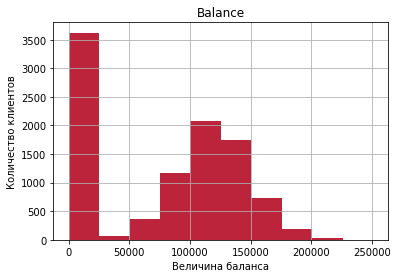

In [5]:
data.hist('Balance', color='#BC243C')
plt.xlabel('Величина баланса')
plt.ylabel('Количество клиентов')
plt.show()

In [6]:
zero_balance = data.query('Balance == 0')
print('Клиентов с нулевым балансом:', len(zero_balance))
zero_balance.head()

Клиентов с нулевым балансом: 3617


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.0,1,1,1,101348.88,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.0,2,0,0,93826.63,0
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.0,2,1,1,10062.80,0
11,12,15737173,Andrews,497,Spain,Male,24,3.0,0.0,2,1,0,76390.01,0
12,13,15632264,Kay,476,France,Female,34,10.0,0.0,2,1,0,26260.98,0


Удалим ненужные признаки

In [7]:
features_ignored = ['RowNumber', 'CustomerId', 'Surname']
data = data.drop(features_ignored, axis=1)

Разделим данные на признаки и целевое значение

In [8]:
X = data.drop('Exited', axis=1)
y = data['Exited']

**Вывод:** 

Датасет состоит из 10 000 объектов и 14 признаков. Из них для обучения модели нам не понадобятся:
* RowNumber индекс строки в данных;
* CustomerId уникальный идентификатор;
* Surname фамилия клиента.

Целевой признак для нашей задачи – Exited, то есть модель, которую мы попытаемся построить, будет предсказывать значение 1 если клиент уйдет или 0 если нет. В этом заключается наша задача классификации, так как целевой признак является категориальным.

Кроме того:

* В датасете представлены клиенты из трех стран EC: Франции ~50%, Германии ~25% и Испании ~25%.
* Признак Tenure (количество недвижимости у клиента) содержит 909 пропусков. Мы их удалили и привели признак к целочисленному типу.
* У 3 283 клиентов банка нулевой баланс на счете. Такая ситуация может быть вполне реалистичной – не у всех клиентов может быть положительный баланс. В реальной практике мы бы обязательно уточнили этот момент у коллег. Если бы мы убрали объекты, у которых баланс меньше 25 000 (это видно по гистограмме), то есть шанс, что модель будет плохо предсказывать в подобных случаях.

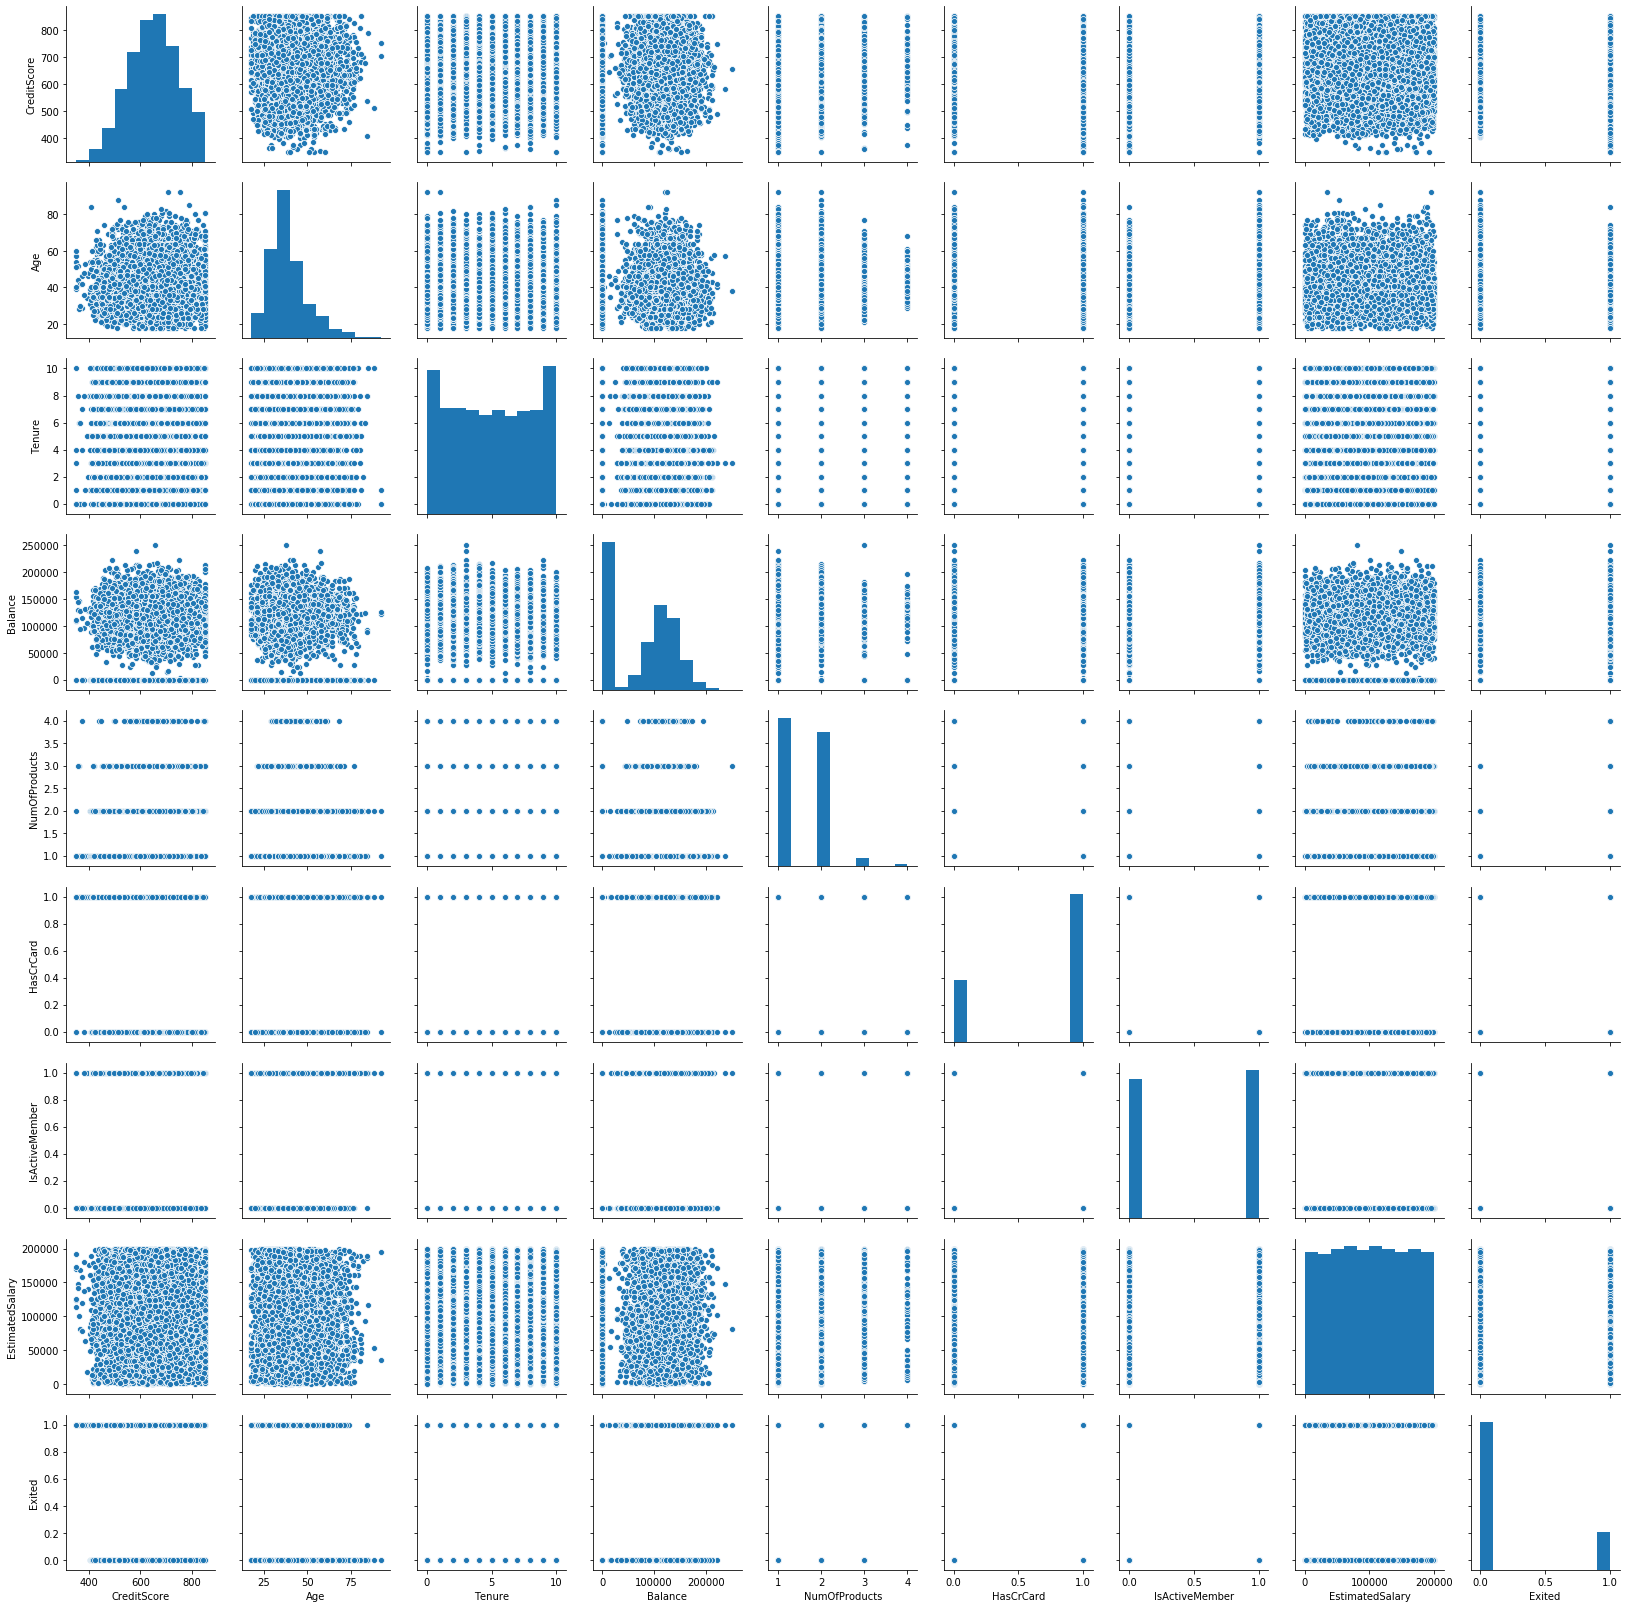

In [9]:
sns.pairplot(data)

pairplot говорит, что между данными нет мультиколлинеарности.

In [10]:
data_not_exit = data[data.Exited == 0]
data_exit = data[data.Exited == 1]

In [11]:
def hist(column, bins_count=10):
    fig, ax = plt.subplots()
    ax.hist(data_not_exit[column], bins=bins_count, alpha=0.5, label='exit', color='#BC243C')
    ax.hist(data_exit[column], bins=bins_count, alpha=0.5, label='not exit', color='#009B77')
    ax.set_title('Распределение по {}'.format(column))
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.legend()
    plt.show()

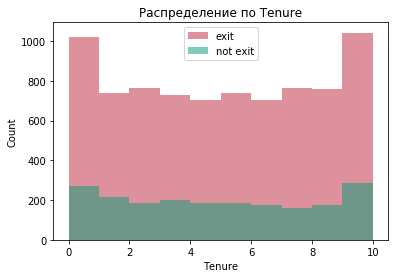

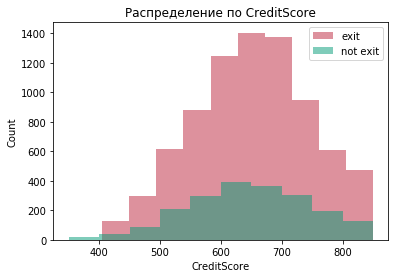

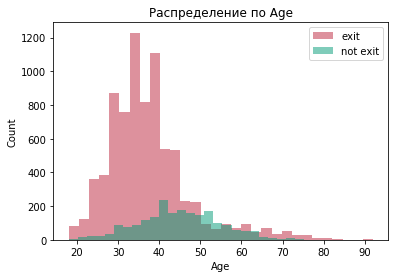

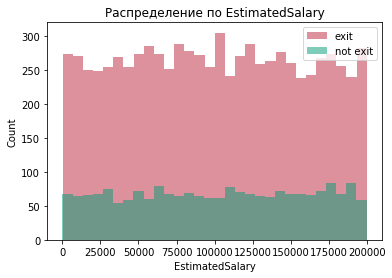

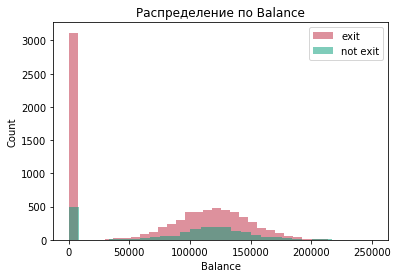

In [12]:
hist('Tenure')
hist('CreditScore')
hist('Age', 30)
hist('EstimatedSalary', 30)
hist('Balance', 30)

Интересно выглядит столбец Tenure, два пика приходиться на людей у которых 0 или 10 единиц недвижимости, видимо стоило бы повысить шкалу более 10 едениц и рассмотреть ее распределение отдельно.

# 2. Исследование задачи <a id='step2'></a>

Выделим категориальные и количественные признаки

In [13]:
cat_feat = ['Geography', 'Gender']
num_feat = X.columns.drop(cat_feat).to_list()

Для категориальных признаков применим OHE

In [14]:
X = pd.get_dummies(X, columns=cat_feat, drop_first=True)
print(X.shape)
X.head(1)

(10000, 11)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.0,1,1,1,101348.88,0,0,0


Разобьем данные на train и test, сохранив баланс классов

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

Проверим дисбаланс целевого класса

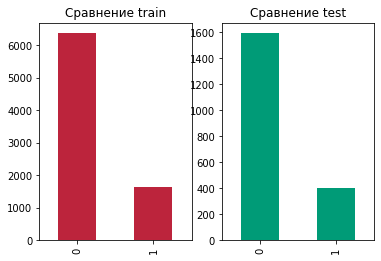

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2)
y_train.value_counts().plot(kind='bar', ax=ax1, label='train', color='#BC243C')
y_test.value_counts().plot(kind='bar', ax=ax2, label='test', color='#009B77')
ax1.set_title('Сравнение train')
ax2.set_title('Сравнение test')
plt.show()

Соотношение классов далеко от 1:1, то есть они несбалансированы: ~80% отрицательных и ~20% положительных.

Рассмотрим три модели - дерево решений, логистическую регрессию и случайный лес.
Для каждого алгоритма подберем лучшие гиперпарамерты поиском по сетке по метрике f1.

Инициализируем валидацию

In [17]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

**Логистическая регрессия**

In [18]:
numeric_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

def scaling(data_ohe):
    scaller = StandardScaler()
    scaller.fit(data_ohe[numeric_columns])

    scaled_data = data_ohe.copy()
    scaled_data.loc[:, numeric_columns] = scaller.transform(scaled_data.loc[:, numeric_columns])
    return scaled_data

X_scaled_train = scaling(X_train)

In [19]:
X_scaled_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2151,1.058568,1.715086,0.789421,-1.226059,-0.910256,1,0,1.042084,0,0,1
8392,0.913626,-0.659935,-0.494582,0.413288,-0.910256,1,0,-0.623556,1,0,1
5006,1.079274,-0.184931,-1.457583,0.601687,0.808830,1,1,0.308128,1,0,0
4117,-0.929207,-0.184931,0.147420,-1.226059,0.808830,1,0,-0.290199,0,0,1
7182,0.427035,0.955079,-1.457583,0.548318,0.808830,0,1,0.135042,1,0,1


In [20]:
param_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
gcv = GridSearchCV(LogisticRegression(solver='liblinear'), param_lr, cv=skf, scoring="f1")
gcv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [21]:
gcv.best_estimator_, gcv.best_score_

(LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                    warm_start=False),
 0.08586002876107243)

**Дерево решений**

In [22]:
tree_parameters = {'max_depth': [1, 3, 5, 7, 9, 11]}
tree = DecisionTreeClassifier(random_state=42)
gcv = GridSearchCV(tree, tree_parameters, n_jobs=-1, cv=skf, verbose=1, scoring="f1")
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11]},
          

In [23]:
gcv.best_estimator_, gcv.best_score_

(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=42, splitter='best'),
 0.5578108760822457)

**Случайный лес**

In [24]:
rfc_parameters = {'n_estimators': [40, 60, 80, 100], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5,10,15,20]}
rfc = RandomForestClassifier(random_state=42, 
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, rfc_parameters, n_jobs=-1, cv=skf, verbose=1, scoring="f1")
gcv.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  3.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=True, random_state=42,
                                              verbose=0, warm_start=False

In [25]:
gcv.best_estimator_, gcv.best_score_

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=15, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
                        oob_score=True, random_state=42, verbose=0,
                        warm_start=False),
 0.5758126286527853)

In [26]:
model_rfc = RandomForestClassifier(random_state=42, n_estimators=60, min_samples_leaf=1, 
                                   max_depth=15, n_jobs=-1, oob_score=True)

**Вывод:** 

Очивидно, что модель случайного леса предсказывает чуть лучше, чем дерево решений и логистическая регрессия. Лучший результат 0.57 достигается при количестве деревьев равном 60 и глубине равной 15.

# 3. Борьба с дисбалансом <a id='step3'></a>

Поробуем бороться с ним используя upsampling и downsampling

In [27]:
def upsampling(X, y, shuffled=True, seed=21):
    
    np.random.seed(seed)
    y_min_value = y.value_counts().sort_values().index[0]
    y_max_value = y.value_counts().sort_values().index[1]
    min_class_cnt = y.value_counts().min()
    max_class_cnt = y.value_counts().max()
    
    coef = max_class_cnt / min_class_cnt - 1
    idx = np.random.randint(0,
                            min_class_cnt,
                            size=np.round(min_class_cnt*coef).astype(int))
    
    X_new = X[y==y_min_value].values[idx]
    y_new = y[y==y_min_value].values[idx]
    
    X_up = pd.concat([X]+[pd.DataFrame(data=X_new, index=idx, columns=X.columns)])
    y_up = pd.concat([y]+[pd.Series(data=y_new, index=idx)])
    
    if shuffled:
        return shuffle(X_up, y_up, random_state=seed)
    else:
        return X_up, y_up

Text(0.5, 0.98, 'upsampling')

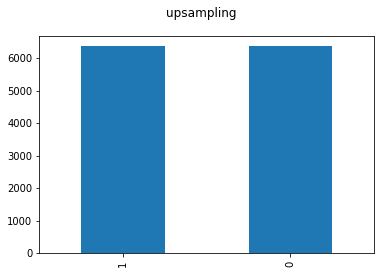

In [28]:
X_train_up, y_train_up = upsampling(X_train, y_train)

y_train_up.value_counts().plot(kind='bar')
X_train_up.shape, y_train_up.shape
plt.suptitle("upsampling")

Так видим upsampling помог выровнять дисбаланс классов

Дополнительно проверим не сломали ли мы распределение признаков на примере CreditScore

Text(0.5, 0.98, 'CreditScore')

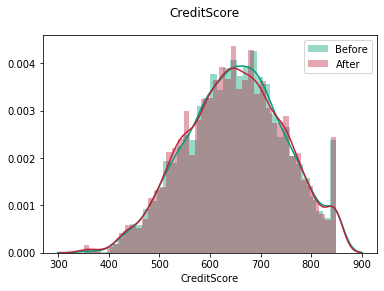

In [29]:
sns.distplot(X_train['CreditScore'], label='Before', color='#009B77')
sns.distplot(X_train_up['CreditScore'], label="After", color='#BC243C')
plt.legend()
plt.suptitle("CreditScore")

Как мы видим распределения практически идентичные
Реализуем downsampling, и выполним такие же проверки

In [30]:
def downsampling(X, y, shuffled=True, seed=21):
      
    np.random.seed(seed)
    y_min_value = y.value_counts().sort_values().index[0]
    y_max_value = y.value_counts().sort_values().index[1]
    min_class_cnt = y.value_counts().min()
    max_class_cnt = y.value_counts().max()
    
    idx = np.random.choice(max_class_cnt,
                           size=max_class_cnt - min_class_cnt,
                           replace=False)   
    print(idx.shape, max_class_cnt - min_class_cnt)
  
    X_down = X.drop(X[y==y_max_value].index[idx])
    y_down = y.drop(y[y==y_max_value].index[idx])
    
    if shuffled:
        return shuffle(X_down, y_down, random_state=seed)
    else:
        return X_down, y_down

(4740,) 4740


Text(0.5, 0.98, 'downsampling')

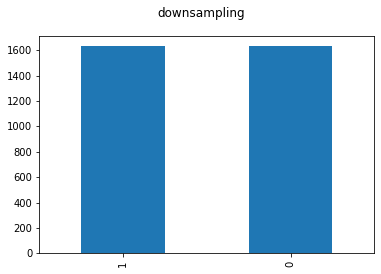

In [31]:
X_train_down, y_train_down = downsampling(X_train, y_train)

y_train_down.value_counts().plot(kind='bar')
X_train_down.shape, y_train_down.shape
plt.suptitle("downsampling")

Text(0.5, 0.98, 'CreditScore')

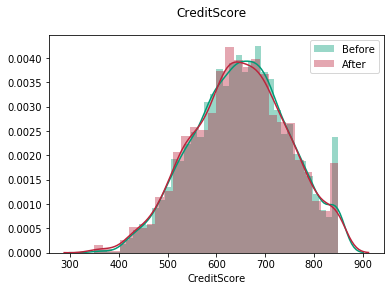

In [32]:
sns.distplot(X_train['CreditScore'], label='Before', color='#009B77')
sns.distplot(X_train_down['CreditScore'], label="After", color='#BC243C')
plt.legend()
plt.suptitle("CreditScore")

In [33]:
results = {'roc_auc_mean': [],
           'roc_auc_std': [],
           'f1_mean': [],
           'f1_std': []}

XX = [X_train, X_train_up, X_train_down]
yy = [y_train, y_train_up, y_train_down]
index = ['source', 'up', 'down']

metrics = ['roc_auc', 'f1']

for x, y, i in zip(XX, yy, index):
    for m in metrics:
        print('Calculate '+ m + ' metrics for '+ i, end='...')
        cv_score = cross_val_score(model_rfc, x, y, cv=skf, scoring=m)
        results[m + '_mean'].append(cv_score.mean())
        results[m + '_std'].append(cv_score.std())
        print('Done!')

pd.DataFrame(data=results, index=index)

Calculate roc_auc metrics for source...Done!
Calculate f1 metrics for source...Done!
Calculate roc_auc metrics for up...Done!
Calculate f1 metrics for up...Done!
Calculate roc_auc metrics for down...Done!
Calculate f1 metrics for down...Done!


,roc_auc_mean,roc_auc_std,f1_mean,f1_std
source,0.851151,0.004805,0.574253,0.011374
up,0.987662,0.001840,0.943893,0.002960
down,0.843311,0.009160,0.752784,0.020647


Мы видим существенный прирост качества на данных с upsampling

Это связано с переобучением модели, так как часть данных в результате перемешивания были и в обучающей и в валидационнй выборке на кросс валидации.

In [34]:
max_iter_array = [1, 3, 5, 7, 10, 15,20,25,100]
model_3 = LogisticRegression()
grid = GridSearchCV(model_3, param_grid={'max_iter': max_iter_array})
grid.fit(X_train, y_train)
best_max_iter = grid.best_estimator_.max_iter
print(grid.best_score_)

0.79625


In [35]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
pipe.fit(X_train, y_train)
Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])
pipe.score(X_test, y_test)

0.86

In [36]:
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))

0.86475
0.86


# 4. Тестирование модели <a id='step4'></a>

Обучим лес и проверим его на тестовой выборке.

In [37]:
model_rfc.fit(X_train_up, y_train_up)
y_pred = model_rfc.predict(X_test)

In [38]:
f1_score(y_test, y_pred)

0.600262123197903

<Figure size 432x288 with 0 Axes>

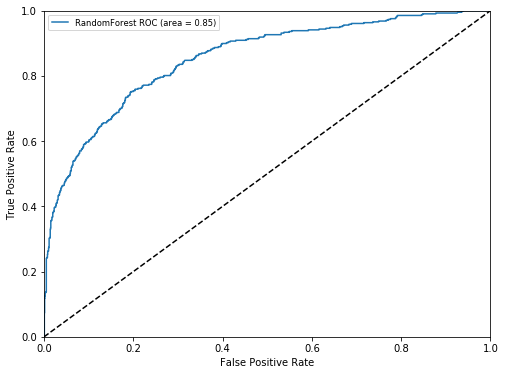

In [39]:
pl.clf()
plt.figure(figsize=(8,6))
probas = model_rfc.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('RandomForest',roc_auc))
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.legend(loc=0, fontsize='small')
pl.show()

AUC-ROC случайной модели равна 0.5 – наша метрика выше и понемногу стремиться к недостижимой едицине.

In [40]:
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)

0.512

In [41]:
dummy_clf.score(y_test, y_pred)

0.4945

In [42]:
f1_score(y_test, y_pred)

0.600262123197903

In [43]:
dummy_clf = DummyClassifier(strategy="uniform", random_state = 3) 
dummy_clf.fit(X_train, y_train)
predicted_test = dummy_clf.predict(X_test)
print('Dummy F1 на тестовой', f1_score(y_test, predicted_test))

Dummy F1 на тестовой 0.28171091445427726


**Вывод:** 

В ходе проекта мы создали модель помогающая предсказывать отток клиентов банка на тестовой выборке и F1-score. Добились мы этого с помощью применения разных текник кодирования, масштабирования данных а также Up sampling и Down Sampling. Разные техники по разному влияли на точность, какие то подошли для логистической регрессии, а какие то для случайного леса. В данной задаче больше подошёл случайный лес.